<a href="https://colab.research.google.com/github/1901010019/FOOD_VISION/blob/main/food_vision_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="color:red; font-family:algerian; background:black; padding:30px 30px"><u><center><b>FOOD VISION PROJECT</b></center></u></h1>

🔑https://arxiv.org/abs/2103.16106 
<h3><P style="color:red; background:black; padding:30px 30px"><b>WE WILL USE TRANSFER LEARNING TO BUILD OUR MODEL
WE WILL TRY TO MATCH THE PREDICTION WITH ORIGINAL FOOD 101 PAPER.</b></P></h3>

WE WILL USE MIXED PRECISION TO TRAIN OUR MODEL. 

🔑 MIXED PRECISION CAN ONLY BE USED WITH GPU's HAVING COMPUTATION NUMBER 7.0+

GOOGLE COLAB PROVIDES US WITH TESLA T4 GPU WHICH IS WELL SUITED FOR MIXED PRECISION TRAINING.

https://www.tensorflow.org/guide/mixed_precision refer to this link for more information.

## QUESTION - WHY WE ARE USING MIXED PRECISION TRAINING?

---



**note** - At this time of making project, tensorflow 2.5+ has some kind of bug and because of it, it throws error while training our model using mixed precision.

there is mainly one reason to that, and that is faster training.
we utilize every resource we have for precessissing.
aslo, we use float16 datatypes to train our model on and float32 datatypes for storage in memory for the purpose of numeric stability.

In [1]:
!pip install tensorflow==2.4.1

     |████████████████████████████████| 394.3 MB 14 kB/s 
     |████████████████████████████████| 2.9 MB 58.4 MB/s 
     |████████████████████████████████| 3.8 MB 38.2 MB/s 
     |████████████████████████████████| 462 kB 55.9 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.

## CHECKING WHICH GPU WE ARE USING!

In [2]:
!nvidia-smi # we are good to go as we have been allocated TESLA T4 GPU, which is very much suitable for mixed precision training.

Thu Aug 12 06:03:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

<h3 style='color:cyan'>IMPORTING ALL IMPORTANT LIBRARIES</h3>

In [3]:
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
tf.__version__

'2.4.1'

<h3>DOWNLOADING OUR PREPROCESSED DATASET</h3>

In [4]:
import tensorflow_datasets as tfds

In [5]:
# list available datasets
datasets_list = tfds.list_builders()
# is the dataset we are after is available?
print('food101' in datasets_list)

True


In [6]:
# now let's download the datasets
(train_data, test_data), ds_info = tfds.load(name="food101", split=['train', 'validation'], 
                            shuffle_files=True, #shuffle files on download 
                                             as_supervised=True , # download data in tuple format, eg. (images,label)
                                             with_info = True # include dataset metadata
                                             )

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteQ714H7/food101-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteQ714H7/food101-validation.tfrecord


Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [7]:
# features of food101 tensorflow datasets
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [8]:
# getting class names
class_names = ds_info.features['label'].names
class_names[:10] # viewing intial 10 class names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### EXPLORING FOOD101 DATASETS FROM TENSORFLOW DATASETS

Now we have downloaded food101 dataset from tensorflow datasets.

let's find out few details about our datasets
* the shape of our input data
* the datatypes of our input data
* what the labels of our input data looks like ( one hot encoded vs label encoded )
* do the labels match up with the class names?

In [9]:
# take one sample of the training data
train_one_sample = train_data.take(1) # will select random one sample

In [10]:
# what does our sample of training data looks like
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [11]:
# output info about our single training sample
for image, label in train_one_sample:
  print(f"""
       image_shape : {image.shape},
       image_dtype : {image.dtype},
       target_class : {label},
       class_name : {class_names[label]}
  """)

# if you keep running this cell, you might come to know that shape of some images are different.


       image_shape : (512, 512, 3),
       image_dtype : <dtype: 'uint8'>,
       target_class : 16,
       class_name : cheesecake
  


In [12]:
# what does an image tensor from tensorflow dataset food101 looks like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 85,  84,  92],
        [ 86,  85,  93],
        [ 93,  92, 100],
        ...,
        [120, 196, 245],
        [120, 198, 246],
        [121, 199, 247]],

       [[ 88,  88,  96],
        [ 82,  82,  90],
        [ 88,  88,  96],
        ...,
        [116, 192, 244],
        [118, 195, 249],
        [119, 196, 248]],

       [[ 77,  80,  89],
        [ 75,  78,  87],
        [ 82,  86,  95],
        ...,
        [115, 189, 252],
        [117, 192, 255],
        [118, 194, 255]],

       ...,

       [[159, 166, 194],
        [154, 161, 187],
        [171, 178, 204],
        ...,
        [219, 216, 235],
        [223, 220, 239],
        [227, 226, 244]],

       [[170, 179, 208],
        [169, 179, 206],
        [173, 183, 210],
        ...,
        [218, 217, 235],
        [223, 222, 240],
        [226, 227, 245]],

       [[168, 177, 206],
        [170, 179, 208],
        [152, 162, 189],
        ...,
        [224, 223, 24

In [13]:
# what are the maxmimum and minimum pixel of images?
tf.reduce_min(image), tf.reduce_max(image) 
# so we have 0 pixel and 255 pixel value as minimum and maximum consecutively

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### LET'S PLOT AN IMAGE FROM TENSORFLOW DATASETS

(-0.5, 511.5, 511.5, -0.5)

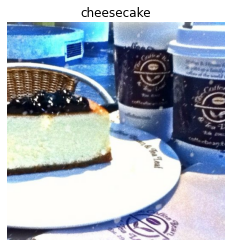

In [14]:
# plot and image tensor
plt.imshow(image)
plt.title(class_names[label])
plt.axis(False)

<h3 style="color:cyan">CREATE PREPROCESSING FUNCTIONS</h3>

OUR DATA IS CURRENTLY
* in `uint8` data type
* comprised of all different sized tensors.
* Not scaled

WHEREAS MODELS LIKE
* `float32` datatype
* same size tensors
* scaled valued ( NORMALIZED )

In [15]:
# make a function for preprocessing images
def preprocess_img(image, label, image_shape=224):
  """
  converts tensors datatype from `uint8` to `float32` and reshape images into [image_shape, image_shape, color_channels]
  """
  image = tf.image.resize(image, [image_shape, image_shape])
  return tf.cast(image, tf.float32), label
  # return tuple (float32_image, label)

In [16]:
# preprocessing a single image using our above built function
preprocessed_image = preprocess_img(image, label)[0]
print(f"image before preprocessing:\n {image[:2]} ...\n\nshape: {image.shape}, \n\ndatatypes: {image.dtype}")
print('\n\n')
print(f"image before preprocessing:\n {preprocessed_image[:2]} ...\n\nshape: {preprocessed_image.shape}, \n\ndatatypes: {preprocessed_image.dtype}")

image before preprocessing:
 [[[ 85  84  92]
  [ 86  85  93]
  [ 93  92 100]
  ...
  [120 196 245]
  [120 198 246]
  [121 199 247]]

 [[ 88  88  96]
  [ 82  82  90]
  [ 88  88  96]
  ...
  [116 192 244]
  [118 195 249]
  [119 196 248]]] ...

shape: (512, 512, 3), 

datatypes: <dtype: 'uint8'>



image before preprocessing:
 [[[ 84.67857   84.321434  92.321434]
  [ 87.19898   86.841835  94.841835]
  [ 84.72959   84.581635  94.72449 ]
  ...
  [119.50503  194.93877  245.85202 ]
  [114.974525 190.97452  241.90309 ]
  [119.071465 196.4286   247.82652 ]]

 [[ 75.647964  84.21939   93.21939 ]
  [ 71.45407   80.959175  89.959175]
  [ 78.03061   87.20408   97.47449 ]
  ...
  [113.31632  182.62755  249.35715 ]
  [106.57655  176.86227  245.4337  ]
  [108.601944 179.9796   248.16833 ]]] ...

shape: (224, 224, 3), 

datatypes: <dtype: 'float32'>


<h3 style="color:cyan">THIS IS HOW CONVOLUTIONAL NEURAL NETWORK 
LOOK LIKE ALONG WITH DENSE LAYER</h3>


<img src='https://miro.medium.com/max/1400/1*uAeANQIOQPqWZnnuH-VEyw.jpeg'>

### TENSORFLOW INPUT PIPELINE
**BATCH AND PREPARE DATASETS**

before we model our data, we have to turn it into the batches because computing on batches is more efficient.

we are going to use tf.data API

thing to note:-

* can't batch tensors of different shape. hence, our `preprocess_img()` function.


In [17]:
# map preprocessing dunction to training data and parallelize
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# shuffle train_data and turn it into batches and prefetch it.
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# map preprocessing function to test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [18]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

### SETTING UP MIXED PRECISION TRAINING

In [19]:
# turning on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy='mixed_float16') # setting global policy to mixed precision

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [20]:
mixed_precision.global_policy() # now we can see it is successfully set to float16

<Policy "mixed_float16">

### CREATING CALLBACKS

In [21]:
import datetime 
# creating tensorboard callback
def create_tensorboard_callback(dir_name, experiment_name):
  """
  this function will create a tensorboard callback instance to store the log files.
  """
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime("%y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"saving tensorboard log files to: {log_dir}")
  return tensorboard_callback

# creating model checkpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving requires '.ckpt' extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='val_accuracy', # save the model weight with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True # only save models weight (not whole model!)
                                                      )

<h3 style="color:cyan">TRANSFER LEARNING WITH FEATURE EXTRACTION USING FUNCTIONAL API:-</h3>

<p>We will use efficientnetbX model in our case as our base model</p>

In [22]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16711680/16705208 [==============================] - 0s 0us/step


<h3 style="color:cyan">ANALYZING OUR MODEL</h3>

In [23]:
model.summary() 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [24]:
model.layers

In [25]:
base_model_layers = model.layers[1].layers # layers inside the efficient net base model
base_model_layers[:10] # viewing starting 10 layers

In [26]:
# let's see our base model layers in nice way!
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [27]:
 base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

### CHECKING LAYER 'dtype' POLICIES

In [28]:
# checkig the dtype policy attributes in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [29]:
# we can also check the same details for our base model also
for layer in model.layers[1].layers[:20]: 
  # only checking first 20 layers to save output space
  print(layer.name, " ", layer.trainable, " ", layer.dtype, " ", layer.dtype_policy)
# one can see that layer.trainable is returning False, because we have set it to False at starting.

input_1   False   float32   <Policy "float32">
rescaling   False   float32   <Policy "mixed_float16">
normalization   False   float32   <Policy "float32">
stem_conv_pad   False   float32   <Policy "mixed_float16">
stem_conv   False   float32   <Policy "mixed_float16">
stem_bn   False   float32   <Policy "mixed_float16">
stem_activation   False   float32   <Policy "mixed_float16">
block1a_dwconv   False   float32   <Policy "mixed_float16">
block1a_bn   False   float32   <Policy "mixed_float16">
block1a_activation   False   float32   <Policy "mixed_float16">
block1a_se_squeeze   False   float32   <Policy "mixed_float16">
block1a_se_reshape   False   float32   <Policy "mixed_float16">
block1a_se_reduce   False   float32   <Policy "mixed_float16">
block1a_se_expand   False   float32   <Policy "mixed_float16">
block1a_se_excite   False   float32   <Policy "mixed_float16">
block1a_project_conv   False   float32   <Policy "mixed_float16">
block1a_project_bn   False   float32   <Policy "mixed_

<h3 style="color:cyan">TRAINING OUR MODEL</h3>

In [30]:
# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=3, # trying just for 5 epochs to make our computation time less (although it will effect the accuracy but we are just experimenting)
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # validating on 15 percent of our test data so as to reduce the running time.
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

saving tensorboard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/210812-061515
Epoch 1/3
2368/2368 [==============================] - 227s 80ms/step - loss: 2.3401 - accuracy: 0.4609 - val_loss: 1.2315 - val_accuracy: 0.6777
Epoch 2/3
2368/2368 [==============================] - 166s 69ms/step - loss: 1.3196 - accuracy: 0.6601 - val_loss: 1.1221 - val_accuracy: 0.7013
Epoch 3/3
2368/2368 [==============================] - 162s 68ms/step - loss: 1.1424 - accuracy: 0.7045 - val_loss: 1.0760 - val_accuracy: 0.7121


<h3 style="color:cyan">PLOTTING LOSS CURVES</h3>

In [31]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

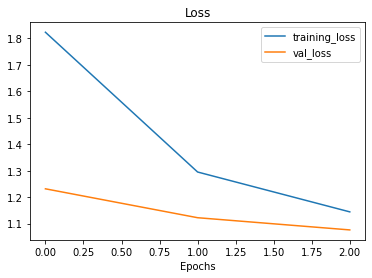

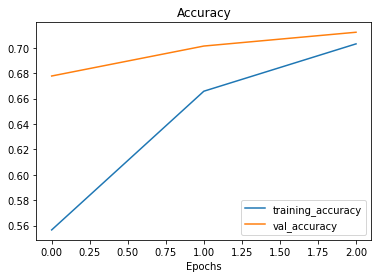

In [32]:
plot_loss_curves(history_101_food_classes_feature_extract)
# we can see that our curves are still converging, so we could have probably used more epochs keeping in mind it does not overfit.
# overfitting occurs when there is large gap in training and validation accuracy. the model learns too much and it's no more generalizes things and we don't want this.

In [33]:
# evaluating on complete test data
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 57s 72ms/step - loss: 1.0826 - accuracy: 0.7079


[1.0825954675674438, 0.7078812122344971]

### LOADING AND EVALUATE CHECKPOINTS WEIGHTS

**note** - since we have used checkpoint callback, we have a saved version of our model in `model_checkpoints` directory

In [34]:
# cloning the model we created 
"""
purpose of doing this is that we want to verify whether the model saved is the same model we trained.

"""
cloned_model = tf.keras.models.clone_model(model) # here we cloned our model (this resets all weights)
cloned_model.summary() # seeing the summary of the model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [35]:
# where our checkpoints stored?
checkpoint_path

'model_checkpoints/cp.ckpt'

In [36]:
# loadind checkpointed weights into our trained model
cloned_model.load_weights(checkpoint_path)

**note** - each time we make any changes to model ( including loading weights ), we have to recompile the model

In [37]:
# recompiling our cloned model
cloned_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [38]:
# evaluating cloned model with laoded weights (should be same as trained model)
results_cloned_model_with_loaded_weights = cloned_model.evaluate(test_data)

790/790 [==============================] - 49s 59ms/step - loss: 1.0852 - accuracy: 0.7059


Cloning the model preserves `dtype_policy's` of layers (but doesn't preserve `weights`) so if we wanted to continue `fine-tuning` with the cloned model, we could and it would still use the mixed precision dtype policy.

In [39]:
# checking the layers in the base model and seeing what data type policy are they using!
for layer in cloned_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <P

### SAVING THE WHOLE MODEL TO A FILE

saving model to google drive

In [40]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [41]:
# creating the path
save_dir = "/content/drive/MyDrive/efficientnetb0_feature_extraction_mixed_precision_model"
model.save(save_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/efficientnetb0_feature_extraction_mixed_precision_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/efficientnetb0_feature_extraction_mixed_precision_model/assets


saving model locally ( the saved file will be lost once the runtime disconnects )

In [42]:
# saving model locally
save_dir = "efficentnetb0_feature_extraction_mixed_precision_model"
model.save(save_dir)

INFO:tensorflow:Assets written to: efficentnetb0_feature_extraction_mixed_precision_model/assets


INFO:tensorflow:Assets written to: efficentnetb0_feature_extraction_mixed_precision_model/assets


**note** :-

* Loading a saved model also retains all of its underlying layers `dtype_policies`

* while loading the model, it produces many types of error, we will just ignore it as this is a issue on github which is yet to be solved on time of making of this project.

In [43]:
# now loading the saved model
loaded_saved_model = tf.keras.models.load_model(save_dir)

In [44]:
# check the layer in the loaded model and see what data type policy they follow
for layer in loaded_saved_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)
# so as we can see, many layers follow 'mixed_float16' policy

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed_float

In [45]:
results_loaded_saved_model = model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 47s 60ms/step - loss: 1.0826 - accuracy: 0.7079


[1.0825951099395752, 0.7078812122344971]

we will now start with the fine tuning part

# **FINE TUNING**

in fine tuning, we basically make the few top layers of our base model trainable and then after recompiling the model, we start to train with new set of trainable layers.

In [ ]:
# loading our saved model from google drive
loaded_gs_model = tf.keras.models.load_model('/content/drive/MyDrive/efficientnetb0_feature_extraction_mixed_precision_model')

In [47]:
loaded_gs_model.summary() # getting the summary of our loaded model which is same as that feature extraction model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
_________________________________________________________________


In [48]:
# evaluating our loaded model on complete test data
results_loaded_gs_model = loaded_gs_model.evaluate(test_data)
results_loaded_gs_model

790/790 [==============================] - 49s 60ms/step - loss: 1.0826 - accuracy: 0.7079


[1.0825951099395752, 0.7078812122344971]

great! our loaded model is performing as expected

ARE ANY OF THE LAYERS IN OUR LOADED MODEL IS FROZEN?

In [49]:
for layer in loaded_gs_model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


so we can see that every layer in our model is trainable.
let's dive deep and see whether we have any frozen layer in base model

In [50]:
for layer in loaded_gs_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)
# there are no frozen layer in base model also!

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed_float

we are going make use of every layer we have in fine tuning. i.e, we will not freeze any of the layer like we did in case of feature extraction model.

as we have lot of data's, we can make use of every layer. but if we would not be having so much of data, we would have certainly freezed a lot of layer and would have only used few top layers in model training. doing so would have prevented our model from overfitting as model would have learnt a lot of unneccessary patterns and would have been weak in generalization.

### A COUPLE MORE CALLBACK

In [51]:
# setting up early stopping callback if model performace deosnot increse for 3 consecutive epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3)

# create model checkpoint callback to save best model during fine tuning
checkpoint_path = 'fine_tune_checkpoits/'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor='val_loss')

finally, we will make one more callback for lowering learning rate when our model is converging.

**why lowering the learning rate?**

I have found a very good explanation online and here it goes:-

Imagine having a coin at the back of the couch and you're trying to grab with your fingers.

Now think of the learning rate as the size of the movements your hand makes towards the coin.

The closer you get, the smaller you want your hand movements to be, otherwise the coin will be lost.

Our model's ideal performance is the equivalent of grabbing the coin. So as training goes on and our model gets closer and closer to it's ideal performance (also called convergence), we want the amount it learns to be less and less.

To do this we'll create an instance of the ReduceLROnPlateau callback to monitor the validation loss just like the EarlyStopping callback.

Once the validation loss stops improving for two or more epochs, we'll reduce the learning rate by a factor of 5 (e.g. 0.001 to 0.0002).

And to make sure the learning rate doesn't get too low (and potentially result in our model learning nothing), we'll set the minimum learning rate to 1e-7.

In [52]:
# creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2, # multiply the learning rate by 2 (reduce by 5 times)
                                                 patience=2,
                                                 verbose=1, # print our when learning rate goes down
                                                 min_lr=1e-7)

now, we need to recompile our model

In [53]:
loaded_gs_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [54]:
# starting fine tuning
history_101_food_classes_all_data_fine_tune = loaded_gs_model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

saving tensorboard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/210812-063659
Epoch 1/100
2368/2368 [==============================] - 306s 123ms/step - loss: 0.9879 - accuracy: 0.7376 - val_loss: 0.8542 - val_accuracy: 0.7601
INFO:tensorflow:Assets written to: fine_tune_checkpoits/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoits/assets


Epoch 2/100
2368/2368 [==============================] - 290s 121ms/step - loss: 0.5910 - accuracy: 0.8392 - val_loss: 0.7602 - val_accuracy: 0.7950
INFO:tensorflow:Assets written to: fine_tune_checkpoits/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoits/assets


Epoch 3/100
2368/2368 [==============================] - 290s 122ms/step - loss: 0.3275 - accuracy: 0.9084 - val_loss: 0.8163 - val_accuracy: 0.7924
Epoch 4/100
2368/2368 [==============================] - 291s 122ms/step - loss: 0.1642 - accuracy: 0.9534 - val_loss: 0.9475 - val_accuracy: 0.7834

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 5/100
2368/2368 [==============================] - 291s 122ms/step - loss: 0.0491 - accuracy: 0.9883 - val_loss: 1.0308 - val_accuracy: 0.8008


In [55]:
# let's save our model to google drive
loaded_gs_model.save('/content/drive/MyDrive/efficientnetb0_fine_tuned_101_classes_mixed_precision')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/efficientnetb0_fine_tuned_101_classes_mixed_precision/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/efficientnetb0_fine_tuned_101_classes_mixed_precision/assets


In [56]:
# let's also save our model locally
loaded_gs_model.save('efficientnetb0_fine_tuned_101_classes_mixed_precision')

INFO:tensorflow:Assets written to: efficientnetb0_fine_tuned_101_classes_mixed_precision/assets


INFO:tensorflow:Assets written to: efficientnetb0_fine_tuned_101_classes_mixed_precision/assets


In [57]:
results_loaded_gs_model_fine_tuned = loaded_gs_model.evaluate(test_data)

790/790 [==============================] - 55s 70ms/step - loss: 1.0463 - accuracy: 0.7971


In [58]:
results_loaded_gs_model_fine_tuned

[1.046266794204712, 0.7970693111419678]

wohoooo! we beat the result obtained by original Deep food paper.

Deep food paper obtained the result of 77.4 percent

In [ ]:
# loading fine tuned model from google drive
loaded_fine_tuned_gs_model = tf.keras.models.load_model('/content/drive/MyDrive/efficientnetb0_fine_tuned_101_classes_mixed_precision')

In [85]:
loaded_fine_tuned_gs_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
_________________________________________________________________


In [86]:
# evaluating our fine tuned loaded model on total test data
result_loaded_fine_tuned_gs_model = loaded_fine_tuned_gs_model.evaluate(test_data)
result_loaded_fine_tuned_gs_model

790/790 [==============================] - 56s 66ms/step - loss: 1.0463 - accuracy: 0.7971


[1.0462677478790283, 0.7970693111419678]

our saved model is performing as expected!

### VIEW TRAINING RESULTS ON TENSORBOARD

since we tracked our model logs using tensorboard callback, let's upload them and inspect on tensorboard.dev

In [62]:
!tensorboard dev upload --logdir ./training_logs\
  --name 'fine tuned efficientnetb0 on all food101 data'\
  --description 'Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001'\
  --one_shot

2021-08-12 07:06:00.574063: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./training_logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0

Tensorboard can be viewed at

https://tensorboard.dev/experiment/8Sv1U0UXR06Ogycy74zzkA/

In [63]:
# View past TensorBoard experiments
!tensorboard dev list

2021-08-12 07:14:45.550404: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
https://tensorboard.dev/experiment/8Sv1U0UXR06Ogycy74zzkA/
	Name                 fine tuned efficientnetb0 on all food101 data
	Description          Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001
	Id                   8Sv1U0UXR06Ogycy74zzkA
	Created              2021-08-12 07:14:41 (11 seconds ago)
	Updated              2021-08-12 07:14:43 (9 seconds ago)
	Runs                 4
	Tags                 3
	Scalars              32
	Tensor bytes         0
	Binary object bytes  2079943
https://tensorboard.dev/experiment/4jgzjh9vTR69vN6WQ4zg4Q/
	Name                 fine tuned efficientnetb0 on all food101 data
	Description          Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001
	Id                   4jgzjh9vTR69vN6WQ4zg4Q
	Created              2021-07-23 11:01:58


We can see clear signs of overfitting, we can further tune this model.

we can also try different efficientnetbX model and see if the performance of the model increases or not!

the main thing we can do to avoid overfitting is we can freeze some layer and train the model only on few unfreezed layers.

### FURTHER FINE TUNING OUR MODEL WITH LESS NUMBER OF TRAINABLE LAYERS

In [87]:
loaded_fine_tuned_gs_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
_________________________________________________________________


** note ** 

we can also use different pretrained model from tensorflow hub, but we are trying to make our prediction better on efficientnetb0 only.

In [88]:
for layer_number, layer in enumerate(loaded_fine_tuned_gs_model.layers[1].layers):
  print(layer_number, ' ', layer.name, ' --> ', layer.trainable)

0   input_1  -->  True
1   rescaling  -->  True
2   normalization  -->  True
3   stem_conv_pad  -->  True
4   stem_conv  -->  True
5   stem_bn  -->  True
6   stem_activation  -->  True
7   block1a_dwconv  -->  True
8   block1a_bn  -->  True
9   block1a_activation  -->  True
10   block1a_se_squeeze  -->  True
11   block1a_se_reshape  -->  True
12   block1a_se_reduce  -->  True
13   block1a_se_expand  -->  True
14   block1a_se_excite  -->  True
15   block1a_project_conv  -->  True
16   block1a_project_bn  -->  True
17   block2a_expand_conv  -->  True
18   block2a_expand_bn  -->  True
19   block2a_expand_activation  -->  True
20   block2a_dwconv_pad  -->  True
21   block2a_dwconv  -->  True
22   block2a_bn  -->  True
23   block2a_activation  -->  True
24   block2a_se_squeeze  -->  True
25   block2a_se_reshape  -->  True
26   block2a_se_reduce  -->  True
27   block2a_se_expand  -->  True
28   block2a_se_excite  -->  True
29   block2a_project_conv  -->  True
30   block2a_project_bn  -->  Tr

as you can see, we made all of our layers of our base model trainable and then trained our model. now we will only train with top ten layers being set to trainable.

In [89]:
# different layers in our model

for layer in loaded_fine_tuned_gs_model.layers:
  print(layer.name)

input_layer
efficientnetb0
pooling_layer
dense
softmax_float32


In [90]:
# leaving above 10 layers, we will freeze all the layers.

for layer in loaded_fine_tuned_gs_model.layers[1].layers[:-10]:
  layer.trainable = False

In [91]:
# let's look at the layers of our base model now.

for layer_number, layer in enumerate(loaded_fine_tuned_gs_model.layers[1].layers):
  print(layer_number, ' ', layer.name, ' --> ', layer.trainable)

# we can see now, only top ten layers are trainable now.

0   input_1  -->  False
1   rescaling  -->  False
2   normalization  -->  False
3   stem_conv_pad  -->  False
4   stem_conv  -->  False
5   stem_bn  -->  False
6   stem_activation  -->  False
7   block1a_dwconv  -->  False
8   block1a_bn  -->  False
9   block1a_activation  -->  False
10   block1a_se_squeeze  -->  False
11   block1a_se_reshape  -->  False
12   block1a_se_reduce  -->  False
13   block1a_se_expand  -->  False
14   block1a_se_excite  -->  False
15   block1a_project_conv  -->  False
16   block1a_project_bn  -->  False
17   block2a_expand_conv  -->  False
18   block2a_expand_bn  -->  False
19   block2a_expand_activation  -->  False
20   block2a_dwconv_pad  -->  False
21   block2a_dwconv  -->  False
22   block2a_bn  -->  False
23   block2a_activation  -->  False
24   block2a_se_squeeze  -->  False
25   block2a_se_reshape  -->  False
26   block2a_se_reduce  -->  False
27   block2a_se_expand  -->  False
28   block2a_se_excite  -->  False
29   block2a_project_conv  -->  False
30

In [94]:
# let's recompile our model

loaded_fine_tuned_gs_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [96]:
# let's train our fine tuned model

# starting fine tuning
history_of_final_fine_tuned_model = loaded_fine_tuned_gs_model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

saving tensorboard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/210812-082423
Epoch 1/100
2368/2368 [==============================] - 194s 81ms/step - loss: 0.0217 - accuracy: 0.9957 - val_loss: 1.1469 - val_accuracy: 0.7995
Epoch 2/100
2368/2368 [==============================] - 190s 80ms/step - loss: 0.0112 - accuracy: 0.9980 - val_loss: 1.2138 - val_accuracy: 0.8043
Epoch 3/100
2368/2368 [==============================] - 193s 78ms/step - loss: 0.0082 - accuracy: 0.9987 - val_loss: 1.2650 - val_accuracy: 0.8024

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 4/100
2368/2368 [==============================] - 190s 77ms/step - loss: 0.0028 - accuracy: 0.9998 - val_loss: 1.2818 - val_accuracy: 0.8059


** NOTE **

* adding dropout layer would have solved our problem of overfitting. The possibilities to further fine tune our model is open. but for now, we will stop the fine tuning. we got almost same validation accuracy even after 'further fune tuning'.